In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import comb, log
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix

In [169]:
#Load dataset
data = load_breast_cancer()
X = data.data
y = data.target

#data normalization
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)

#standerdization
X_scaled = (X - mean) / std

In [170]:
#function used in E-step (expectation step) of GMM to prevent overflow
def calculate_log_sum_exp(log_resp):
    max_val = np.max(log_resp, axis=1, keepdims=True)
    return max_val + np.log(np.sum(np.exp(log_resp - max_val), axis=1, keepdims=True))

In [171]:
#GMM implementation from scratch
#K equivelant to pi
def initialize_gmm_parameters(X, K, covariance_type):
  n_samples, n_features = X.shape
  np.random.seed(42)
  weights = np.ones(K) / K
  indices = np.random.choice(n_samples, K, replace=False)
  means = X[indices]

  if covariance_type == 'full':
    covar_matrix = np.array([np.eye(n_features) for i in range (K)])
  elif covariance_type == 'diagonal':
    covar_matrix = np.ones((K, n_features))
  elif covariance_type == 'spherical':
    covar_matrix = np.ones(K)
  elif covariance_type == 'tied':
    covar_matrix = np.eye(n_features)

  return means, covar_matrix, weights

#computes log(N(x | mean_k, covar_k)) used in E-step
def evaluate_gaussian_log_pdf(X, mean_k, covar_k, ctype):
  n_samples, n_features = X.shape
  # (epsilon) smoothing factor for numerical stability to prevent singularity problem (in lec slide 29)
  eps = 1e-6
  diff = X - mean_k

  if ctype == 'full':
    cov_reg = covar_k + np.eye(n_features) * eps
    try:
      chol = np.linalg.cholesky(cov_reg)
      det_log = 2 * np.sum(np.log(np.diagonal(chol)))
      sol = np.linalg.solve(chol, diff.T)
      maha = np.sum(sol**2, axis=0)
    except: return np.full(n_samples, -np.inf)
  elif ctype == 'diagonal':
    cov_reg = covar_k + eps
    det_log = np.sum(np.log(cov_reg))
    maha = np.sum((diff**2)/cov_reg, axis=1)
  elif ctype == 'spherical':
    cov_reg = covar_k + eps
    det_log = n_features * np.log(cov_reg)
    maha = np.sum(diff**2, axis=1)/cov_reg
  elif ctype == 'tied':
    cov_reg = covar_k + np.eye(n_features) * eps
    try:
      chol = np.linalg.cholesky(cov_reg)
      det_log = 2 * np.sum(np.log(np.diagonal(chol)))
      sol = np.linalg.solve(chol, diff.T)
      maha = np.sum(sol**2, axis=0)
    except: return np.full(n_samples, -np.inf)

  const = n_features * np.log(2 * np.pi)
  return -0.5 * (const + det_log + maha)

In [172]:
#EM E-step and M-step

#evaluate responsibilities given current parameters
def e_step(X, means, covar_matrix, weights, K, covariance_type):
    n_samples = X.shape[0]
    log_resp_unnorm = np.zeros((n_samples, K)) #creates an empty matrix of size NxK to store unnormalized log probabilities (bayes rule numerator)

    #ileterates through each cluster from 1 to k
    for k in range(K):
        #cov_k selects covariance matrix for the current cluster
        #If covariance_type is 'tied', all clusters share the same covariance matrix, else, it picks the specific sigma for cluster k
        cov_k = covar_matrix if covariance_type == 'tied' else covar_matrix[k]

        #calculates numerator [log(weights[k] * N(x | means[k], covar_matrix[k]))]
        log_resp_unnorm[:, k] = np.log(weights[k] + 1e-10) + evaluate_gaussian_log_pdf(X, means[k], cov_k, covariance_type)

    # Normalize via log-sum-exp to get responsibilities

    log_prob_norm = calculate_log_sum_exp(log_resp_unnorm) #calculate denumerator
    responsibilities = np.exp(log_resp_unnorm - log_prob_norm)

    # The sum of log_prob_norm is the total log likelihood
    current_ll = np.sum(log_prob_norm)

    return responsibilities, current_ll

#Re-estimate parameters given current responsibilities
def m_step(X, responsibilities, K, covariance_type, means, covar_matrix):
    n_samples, n_features = X.shape

    # Nk = sum(responsibilities)
    Nk = responsibilities.sum(axis=0) + 1e-10

    # Update weights = Nk / N
    weights_new = Nk / n_samples

    # Update means = (1/Nk) * sum(resp * x)
    means_new = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]

    # Update covar_matrix
    covar_matrix_new = None
    if covariance_type == 'full':
        covar_matrix_new = np.zeros((K, n_features, n_features))
        for k in range(K):
            diff = X - means_new[k]
            # (1/Nk) * sum(resp * (x-mean)(x-mean)^T)
            covar_matrix_new[k] = np.dot(responsibilities[:, k] * diff.T, diff) / Nk[k]

    elif covariance_type == 'diagonal':
        covar_matrix_new = np.zeros((K, n_features))
        for k in range(K):
            covar_matrix_new[k] = np.sum(responsibilities[:, k, np.newaxis] * (X - means_new[k])**2, axis=0) / Nk[k]

    elif covariance_type == 'spherical':
        covar_matrix_new = np.zeros(K)
        for k in range(K):
            covar_matrix_new[k] = np.sum(responsibilities[:, k, np.newaxis] * (X - means_new[k])**2) / Nk[k] / n_features

    elif covariance_type == 'tied':
        cov_tied = np.zeros((n_features, n_features))
        for k in range(K):
            diff = X - means_new[k]
            cov_tied += np.dot(responsibilities[:, k] * diff.T, diff)
        covar_matrix_new = cov_tied / n_samples

    return means_new, covar_matrix_new, weights_new


In [173]:
#train model
def train_gmm(X, K, covariance_type='full', max_iter=50):
    # 1. Initialize parameters
    means, covar_matrix, weights = initialize_gmm_parameters(X, K, covariance_type)
    prev_ll = -np.inf

    responsibilities = None

    for i in range(max_iter):
        # 2. E-step
        responsibilities, curr_ll = e_step(X, means, covar_matrix, weights, K, covariance_type)

        # Check convergence
        if abs(curr_ll - prev_ll) < 1e-4: break
        prev_ll = curr_ll

        # 3. M-step
        means, covar_matrix, weights = m_step(X, responsibilities, K, covariance_type, means, covar_matrix)

    return {'labels': np.argmax(responsibilities, axis=1),
            'final_ll': prev_ll,
            'n_components': K,
            'covariance_type': covariance_type,
            'means': means,
            'covar_matrix': covar_matrix,
            'weights': weights}

In [174]:
# positives values only
def relu(z):
    return np.maximum(0, z)

# 1 for +ve values 0 for else
#.astype(float) -> must be 0 or 1 not boolean
def relu_deriv(z):
    return (z>0).astype(float)

def sigmoid(z):
    return 1/(1 + np.exp(-z))

#σ′(z)=σ(z)(1−σ(z))
def sigmoid_deriv(z):
    s =sigmoid(z)
    return s*(1-s)

def tanh(z):
    return np.tanh(z)

#d/d ​tanh(z)=1−tanh^2(z)
def tanh_deriv(z):
    return 1 - np.tanh(z)**2


def linear(x):
    return x


def linear_deriv(x):
    return 1

In [175]:
#AutoEncoder
class Autoencoder:
  #layer_dimensions->list with dimensions ofa eacher layer from enoder to bottleneck to decoder
  #activations->a dictionary mapping each layer to its activation function
  #lr learning rate ->s step size during gradient descent
  # lambda l2 regularization
  #L->
    def __init__(self,layer_dimensions,lr=0.01,l2=1e-4):
        self.lr=lr
        self.l2=l2
        #w-> weight matrix , b bias
        self.L=len(layer_dimensions)-1
        self.W,self.b ={}, {}
        self.activations = {
    1: relu,
    2: relu,
    3: sigmoid,
    4: linear
}

        self.activation_derivs = {
    1: relu_deriv,
    2: relu_deriv,
    3: sigmoid_deriv,
    4: linear_deriv
}

        # iterates through layers
        #np.random.randn->samples from standard normal distribution mean=0 std=1
        for i in range(1, self.L+ 1):
          #if I initialised with all zeros neurons learn the same things
          #if all weights start the same:all neurons receive identical gradients and remain identical
          # *0.01-> scaling cause when weights are large z=wx z is larger
          #w n(i)*n(i-1)  A  m*n(i-1)   z m*n(i)
            #self.W[i]=np.random.randn(layer_dimensions[i-1],layer_dimensions[i])*0.01
            fan_in = layer_dimensions[i-1]
            fan_out = layer_dimensions[i]

    # He initialization (good for ReLU)
            limit = np.sqrt(2.0 / fan_in)
            self.W[i] = np.random.randn(fan_in, fan_out) * limit
            self.b[i] = np.zeros((1, fan_out))
          #b[i].shape =(1-> no of rows,no of neuros in the layer)


    def train(self, X, epochs=100, batch_size=32, decay=0.99):
        losses = []
        #epoch->one full pass over the entire dataset
        #np.random.permutation(len(X))creates a random permutation of indices from 0 to len(X)
        #reorders the dataset X according to this permutation.
        for e in range(epochs):
            perm = np.random.permutation(len(X))
            X_shuffled=X[perm]
        #iterates over the dataset in chunks of size batch_size
            for i in range(0, len(X), batch_size):
              #extracts the mini-batch
                batch = X_shuffled[i:i+batch_size]
                out = self.forward(batch)
                self.backward(batch)
                #decays the learning rate so the training converge smoothly
            self.lr *= decay
            #MSE loss 1/n (x telda -x)^2
            loss = np.mean((self.forward(X) - X) ** 2)
            losses.append(loss)
        return losses

    def forward(self, X):
      #Initialize storage for intermediate values
      #A stores activations of all layers
      #Treats the input as the activation of layer 0
        self.A,self.Z ={0: X},{}
        # A[i-1]features learnt so far
        #w[i]learns how to combine features
        # bias shifts the activation threshold
        # @ matrix multiplication
        for i in range(1, self.L+1):
          #z -> the output of the layer
          #apply an activation to z to add non-linearity

            self.Z[i]=self.A[i-1]@self.W[i]+self.b[i]
            self.A[i] = self.activations[i](self.Z[i])
        return self.A[self.L]


#Backpropagation tells each weight how to change to make the output closer to the input.
#Computes how much each weight contributed to the error
#Uses the chain rule to propagate error from output to input
#Updates parameters to reduce reconstruction loss
    def backward(self, X):
        m = X.shape[0]
        # dz/dl = x telda -x
        dZ = self.A[self.L]-X
        for i in reversed(range(1, self.L + 1)):
          #.T->transpose
          #regularization cause it's easy to get output which is the input so it could memorize the data so it helps to generalize effectively
            dW = (self.A[i-1].T @ dZ) / m + self.l2 * self.W[i]
            #loops over all samples so we take the average
            db = np.mean(dZ,axis=0,keepdims=True)
            if i > 1:
                dZ = (dZ @ self.W[i].T) * self.activation_derivs[i-1](self.Z[i-1])
                #update the weight and bias
                #w=w-lr*dw
                #b=b-lr*db
            self.W[i] -= self.lr * dW
            self.b[i] -= self.lr * db

    def encode(self, X):

        self.A = {0: X}  # reset storage after forward
        self.Z = {}\
        # goes to the encoder and bottleneck only
        bottleneck_index = self.L // 2
        for i in range(1, bottleneck_index + 1):
            self.Z[i] = self.A[i-1] @ self.W[i] + self.b[i]
            self.A[i] = self.activations[i](self.Z[i])

        return self.A[bottleneck_index]

In [176]:
#PCA
def pca_fit(X, n_components):

    # Center the data around 0
    mean = np.mean(X, axis=0)
    X_centered = X - mean

    # Compute covariance matrix
    n_samples = X_centered.shape[0]     # no. of rows
    cov = np.dot(X_centered.T, X_centered) / (n_samples - 1) # shows how features correlate with each other

    # Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov)

    # Sort by importance
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

     # dimensionality reduction
    #  Select top components :Choose how many components to keep

    components = eigenvectors[:, :n_components]

    explained_variance = eigenvalues[:n_components]
    explained_variance_ratio = explained_variance / np.sum(eigenvalues)

    return components, explained_variance, explained_variance_ratio, mean

# Project data
def pca_transform(X, components, mean):
    # z= U.t * X
    X_centered = X - mean
    return X_centered @ components

def pca_inverse_transform(Z, components, mean):
    # proj(x) = UZ
    return Z @ components.T + mean

def pca_reconstruction_error(X, X_reconstructed):
    return np.mean((X - X_reconstructed) ** 2)

In [177]:
# Calculates Clustering Purity
def calculate_purity(y_true, y_pred):
    clusters = np.unique(y_pred) #finds all unique cluster ids
    count_sum = 0
    for cluster in clusters:
        #resulted cluster_labels contains only the actual ground truth labels for data inside a specific cluster
        cluster_labels = y_true[y_pred == cluster]
        #checks if a cluster is not empty before starting
        if len(cluster_labels) > 0:
            counts = np.bincount(cluster_labels) #counts how many times each true label appears in this specific cluster
            count_sum += np.max(counts) #identifies the majority class in this cluster and adds that count to the total.
    return count_sum / len(y_true) # division to make sure that ratio is between 0-1

In [178]:
# Calculates Calinski-Harabasz Index (Variance Ratio Criterion)
def calculate_calinski_harabasz(X, labels):
    n_samples = X.shape[0] #Gets the total number of data points in the dataset
    classes = np.unique(labels) #Finds all the unique cluster IDs present in the labels array
    n_classes = len(classes) #Counts how many unique clusters exist

    #safty check to check if there are atleast 2 clusters to be calculated
    if n_classes < 2: return 0.0

    mean_global = np.mean(X, axis=0) # Calculates the global centroid (mean) of the entire dataset. This represents the center point of all data combined
    WG = 0.0 # Within group
    BG = 0.0 # Between group

    #Starts a loop to iterate through each unique cluster ID
    for c in classes:
        points = X[labels == c] #Filters the dataset X to get only the data points that belong to the current cluster c
        mean_k = np.mean(points, axis=0) #Calculates the centroid (mean) of the current cluster c

        #Calculates the squared distance between each point in the cluster and that cluster's centroid (mean_k)
        #Sums these squared distances and adds them to the running total WG
        WG += np.sum((points - mean_k) ** 2)
        #Calculates the squared distance between the current cluster's centroid (mean_k) and the global dataset centroid (mean_global)
        #Weights this distance by the number of points in the cluster
        #Adds it to the running total
        BG += points.shape[0] * np.sum((mean_k - mean_global) ** 2)

    #Computes the final ratio
    score = (BG / (n_classes - 1)) / (WG / (n_samples - n_classes))
    return score

In [179]:
# Calculates AIC and BIC.
# BIC = k*ln(n) - 2*ln(L)
# AIC = 2*k - 2*ln(L)
def calculate_aic_bic(model, X):
    n_samples, n_features = X.shape
    n_components = model['n_components']
    cov_type = model['covariance_type']
    log_likelihood = model['final_ll']

    # Calculate number of free parameters
    n_params_weights = n_components - 1
    n_params_means = n_components * n_features

    if cov_type == 'full':
        n_params_cov = n_components * n_features * (n_features + 1) / 2
    elif cov_type == 'diagonal':
        n_params_cov = n_components * n_features
    elif cov_type == 'spherical':
        n_params_cov = n_components
    elif cov_type == 'tied':
        n_params_cov = n_features * (n_features + 1) / 2

    n_params = n_params_weights + n_params_means + n_params_cov

    bic = n_params * np.log(n_samples) - 2 * log_likelihood
    aic = 2 * n_params - 2 * log_likelihood

    return aic, bic

In [180]:
# WCSS (Inertia)
def compute_inertia(X, centroids, labels):
    inertia = 0
    for i in range(len(centroids)):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            inertia += np.sum((cluster_points - centroids[i]) ** 2)
    return inertia

# Adjusted Rand Index (ARI)
def adjusted_rand_index(labels_true, labels_pred):
   #convert them to numpy arrays
    labels_true = np.array(labels_true)
    labels_pred = np.array(labels_pred)

    n = len(labels_true)
    #max label +1 [0 1]-> 2 rows needed same for columns and fill them with zeros
    contingency = np.zeros((labels_true.max()+1, labels_pred.max()+1), dtype=int)

    for i in range(n):
      # for wvery sample fills the table
        contingency[labels_true[i], labels_pred[i]] += 1

    #for every row all pairs of points that are in the same true cluster.
    sum_comb_c= sum(comb(n_c, 2) for n_c in contingency.sum(axis=1))
    #for every column all pairs in the same predicted cluster.
    sum_comb_k= sum(comb(n_k, 2) for n_k in contingency.sum(axis=0))
    #This is the number of pairs that are in the same cluster in both true and predicted labels.
    sum_comb= sum(comb(n_ij, 2) for n_ij in contingency.flatten())
    comb_n = comb(n, 2)

    #Expected index: expected number of agreements by chance.
    #Maximum index: maximum possible number of agreements.
    expected_index = sum_comb_c * sum_comb_k / comb_n
    max_index = 0.5 * (sum_comb_c + sum_comb_k)
    #Observed−Expected/Maximum−Expected​
    ari = (sum_comb - expected_index) / (max_index - expected_index)
    return ari

# Normalized Mutual Information (NMI)
def normalized_mutual_info(labels_true, labels_pred):
    #convert them to numpy arrays
    labels_true = np.array(labels_true)
    labels_pred = np.array(labels_pred)
    #no of samples
    n = len(labels_true)
    #the true labels and clusters
    unique_true = np.unique(labels_true)
    unique_pred = np.unique(labels_pred)

    # Compute probabilities of true classses and the clusters
    #number of samples in class i/n
    #number of samples in cluster j/n
    p_true = np.array([np.sum(labels_true==c)/n for c in unique_true])
    p_pred = np.array([np.sum(labels_pred==c)/n for c in unique_pred])

    # Joint probability-> This tells you how many points belong to class i and cluster j
    p_joint = np.zeros((len(unique_true), len(unique_pred)))
    for i, c_true in enumerate(unique_true):
        #compares each true label with true labels
        #compares each predicted label with the rest
        # then compare them with each other and sum them and divide by n to calculate the probability
        for j, c_pred in enumerate(unique_pred):
            p_joint[i,j] = np.sum((labels_true==c_true) & (labels_pred==c_pred)) / n

    # Mutual information-> if knowing cluster helps with knowing labels
    #p(y,c)/p(y)p(c)
    #if independent p(y,c)=p(y)p(c)->0 no informain gain

    MI = 0
    for i in range(len(unique_true)):
        for j in range(len(unique_pred)):
            if p_joint[i,j] > 0:
                MI += p_joint[i,j] * log(p_joint[i,j]/(p_true[i]*p_pred[j]))

    # Entropies
    H_true = -np.sum(p_true * np.log(p_true + 1e-10))
    H_pred = -np.sum(p_pred * np.log(p_pred + 1e-10))

    NMI = MI / ((H_true + H_pred)/2)
    return NMI

In [181]:
# Davies-Bouldin Index
def davies_bouldin_index(X, labels):
    unique_labels = np.unique(labels)
    k = len(unique_labels)
    if k < 2: return 0.0

    centroids = []
    for l in unique_labels:
        centroids.append(np.mean(X[labels == l], axis=0))
    centroids = np.array(centroids)

    scatters = []
    for i, l in enumerate(unique_labels):
        cluster_points = X[labels == l]
        if len(cluster_points) > 0:
            scatter = np.mean(np.linalg.norm(cluster_points - centroids[i], axis=1))
            scatters.append(scatter)
        else:
            scatters.append(0)
    scatters = np.array(scatters)

    db_values = []
    for i in range(k):
        max_ratio = -np.inf
        for j in range(k):
            if i != j:
                dist_centroids = np.linalg.norm(centroids[i] - centroids[j])
                if dist_centroids == 0: ratio = 0
                else: ratio = (scatters[i] + scatters[j]) / dist_centroids
                max_ratio = max(max_ratio, ratio)
        if max_ratio == -np.inf: db_values.append(0)
        else: db_values.append(max_ratio)

    return np.mean(db_values)

In [182]:
# Silhouette Score
def silhouette_score(X, labels):
    n = len(X)
    if len(np.unique(labels)) < 2: return 0.0
    scores = []

    # Pre-calculate clusters for speed
    unique_labs = np.unique(labels)
    clusters_data = {l: X[labels == l] for l in unique_labs}

    for i in range(n):
        my_label = labels[i]
        same_cluster = clusters_data[my_label]

        # Distance to own cluster (a)
        if len(same_cluster) > 1:
            a = np.mean(np.linalg.norm(same_cluster - X[i], axis=1))
        else:
            a = 0

        # Distance to nearest other cluster (b)
        b = np.inf
        for l in unique_labs:
            if l != my_label:
                other_cluster = clusters_data[l]
                if len(other_cluster) > 0:
                    dist = np.mean(np.linalg.norm(other_cluster - X[i], axis=1))
                    if dist < b: b = dist

        if b == np.inf: b = 0 # Handle case with 1 cluster effectively

        scores.append((b - a) / max(a, b))

    return np.mean(scores)

In [183]:
# Map clusters to true labels
def match_clusters_to_labels(y_true, clusters):
    mapping = {}
    for cluster in np.unique(clusters):
        true_labels = y_true[clusters == cluster]
        mapping[cluster] = np.bincount(true_labels).argmax()
    return mapping

In [184]:
#Experiments
def run_experiments(X, y_true):
    results = []

    def evaluate(model, data, exp_name, dim, k, cv):
        aic, bic = calculate_aic_bic(model, data)
        pur = calculate_purity(y_true, model['labels'])
        ch = calculate_calinski_harabasz(data, model['labels'])
        nmi = normalized_mutual_info(y_true, model['labels'])
        ari = adjusted_rand_index(y_true, model['labels'])
        db = davies_bouldin_index(data, model['labels'])
        sil = silhouette_score(data, model['labels'])
        wcss = compute_inertia(data, model['means'], model['labels'])

        print(f"  {exp_name} | Dim:{dim} | K:{k} | {cv} -> BIC:{bic:.0f}, Pur:{pur:.2f}, ARI:{ari:.2f}, NMI:{nmi:.2f}")
        return {
            'Experiment': exp_name, 'Dim': dim, 'K': k, 'Cov': cv,
            'BIC': bic, 'AIC': aic, 'Purity': pur, 'CH': ch,
            'NMI': nmi, 'ARI': ari, 'DB_Index': db, 'Silhouette': sil, 'WCSS': wcss
        }

    # EXP 2: Original Data
    print("\n--- Experiment 2: GMM on Original Data ---")
    for k in [2, 3]:
        for cv in ['full', 'diagonal', 'spherical']:
            model = train_gmm(X, k, cv)
            results.append(evaluate(model, X, 'Exp2', 30, k, cv))

    # EXP 4: GMM after PCA
    print("\n--- Experiment 4: GMM after PCA ---")
    dims = [2, 5, 10]
    for d in dims:
        components, _, _, mean_val = pca_fit(X, d)
        X_pca = pca_transform(X, components, mean_val)

        for k in [2]:
            for cv in ['full', 'diagonal']:
                model = train_gmm(X_pca, k, cv)
                results.append(evaluate(model, X_pca, 'Exp4', d, k, cv))

    # EXP 6: GMM after Autoencoder
    print("\n--- Experiment 6: GMM after Autoencoder ---")

    for d in dims:
        input_dim = X.shape[1]
        # Layer dims must correspond to the keys in self.activations (1,2,3,4)
        # 0: Input, 1: 50, 2: Bottleneck(d), 3: 50, 4: Output
        layer_dims = [input_dim, 50, d, 50, input_dim]

        # Initialize and Train
        ae = Autoencoder(layer_dimensions=layer_dims, lr=0.01)
        ae.train(X, epochs=50, batch_size=32) # Using 50 epochs

        # Get Latent Representation
        X_ae = ae.encode(X)

        for k in [2]:
            for cv in ['full', 'diagonal']:
                model = train_gmm(X_ae, k, cv)
                results.append(evaluate(model, X_ae, 'Exp6', d, k, cv))

    return pd.DataFrame(results)

Loaded Data: (569, 30)

--- Experiment 2: GMM on Original Data ---
  Exp2 | Dim:30 | K:2 | full -> BIC:-38150, Pur:0.95, ARI:0.82, NMI:0.71
  Exp2 | Dim:30 | K:2 | diagonal -> BIC:-7340, Pur:0.91, ARI:0.68, NMI:0.56
  Exp2 | Dim:30 | K:2 | spherical -> BIC:185549, Pur:0.91, ARI:0.66, NMI:0.56
  Exp2 | Dim:30 | K:3 | full -> BIC:-36987, Pur:0.88, ARI:0.51, NMI:0.48
  Exp2 | Dim:30 | K:3 | diagonal -> BIC:-9483, Pur:0.85, ARI:0.50, NMI:0.50
  Exp2 | Dim:30 | K:3 | spherical -> BIC:173202, Pur:0.89, ARI:0.41, NMI:0.45

--- Experiment 4: GMM after PCA ---
  Exp4 | Dim:2 | K:2 | full -> BIC:14718, Pur:0.93, ARI:0.75, NMI:0.65
  Exp4 | Dim:2 | K:2 | diagonal -> BIC:14928, Pur:0.89, ARI:0.59, NMI:0.50
  Exp4 | Dim:5 | K:2 | full -> BIC:26459, Pur:0.93, ARI:0.73, NMI:0.62
  Exp4 | Dim:5 | K:2 | diagonal -> BIC:27421, Pur:0.89, ARI:0.61, NMI:0.51
  Exp4 | Dim:10 | K:2 | full -> BIC:31325, Pur:0.94, ARI:0.79, NMI:0.68
  Exp4 | Dim:10 | K:2 | diagonal -> BIC:32964, Pur:0.79, ARI:0.33, NMI:0.23

-

/tmp/ipython-input-1300060367.py:11: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))


  Exp6 | Dim:2 | K:2 | full -> BIC:1910, Pur:0.89, ARI:0.61, NMI:0.53
  Exp6 | Dim:2 | K:2 | diagonal -> BIC:1898, Pur:0.89, ARI:0.61, NMI:0.53
  Exp6 | Dim:5 | K:2 | full -> BIC:20774, Pur:0.92, ARI:0.70, NMI:0.58
  Exp6 | Dim:5 | K:2 | diagonal -> BIC:48516, Pur:0.91, ARI:0.65, NMI:0.55
  Exp6 | Dim:10 | K:2 | full -> BIC:5976, Pur:0.90, ARI:0.64, NMI:0.56
  Exp6 | Dim:10 | K:2 | diagonal -> BIC:57996, Pur:0.91, ARI:0.66, NMI:0.56

Top 5 Models by BIC (Lower is Better):
   Experiment  Dim  K       Cov           BIC           AIC    Purity  \
0        Exp2   30  2      full -38150.028564 -42454.814075  0.952548   
3        Exp2   30  3      full -36986.912189 -43446.262395  0.875220   
4        Exp2   30  3  diagonal  -9483.279001 -10273.865240  0.854130   
1        Exp2   30  2  diagonal  -7340.124338  -7865.733870  0.912127   
13       Exp6    2  2  diagonal   1897.742779   1858.647855  0.891037   

             CH       NMI       ARI  DB_Index  Silhouette          WCSS  
0    669.3

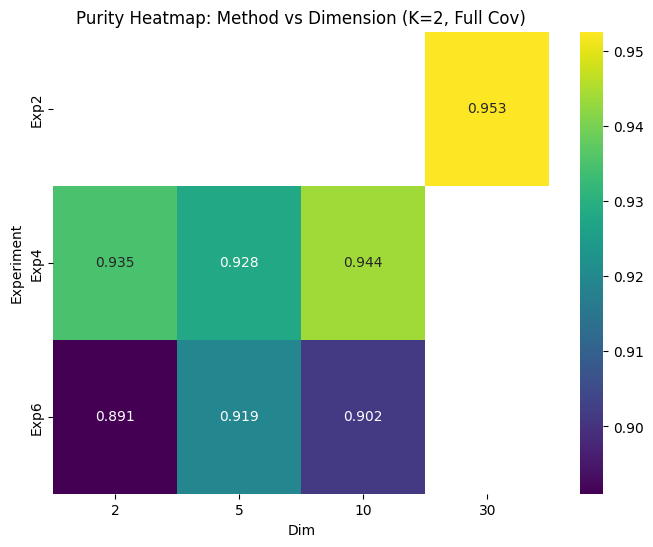

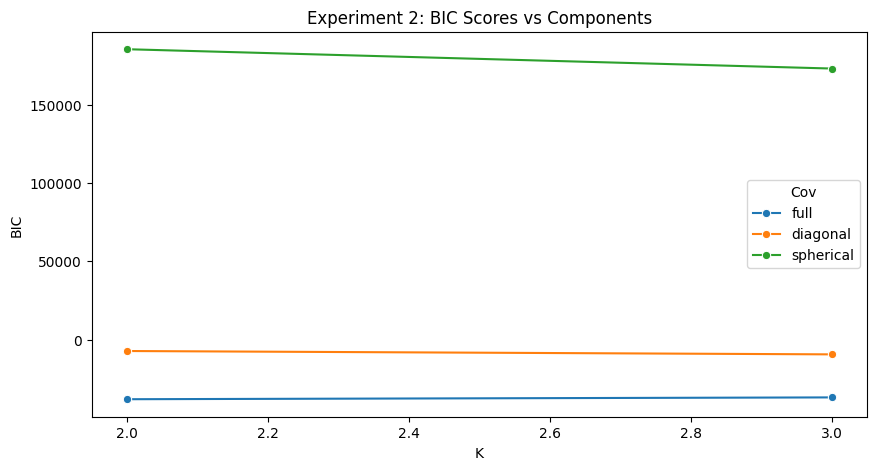

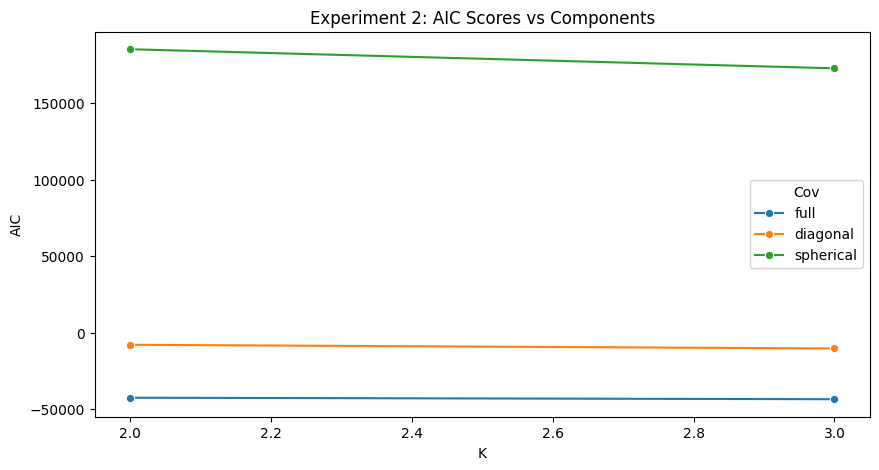


--- Running Silhouette Analysis (K=2 to 10) ---


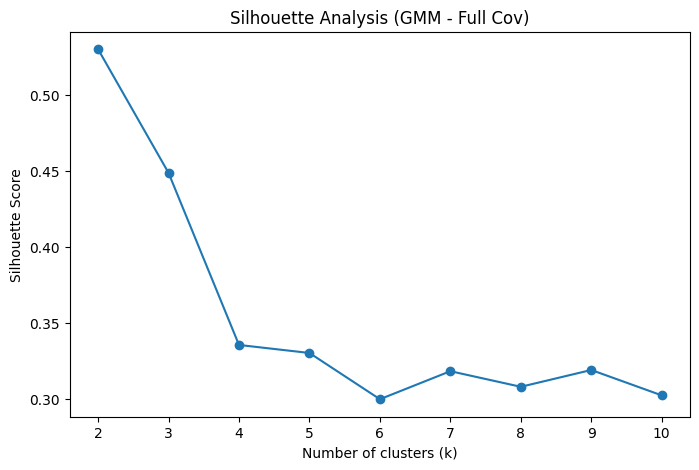

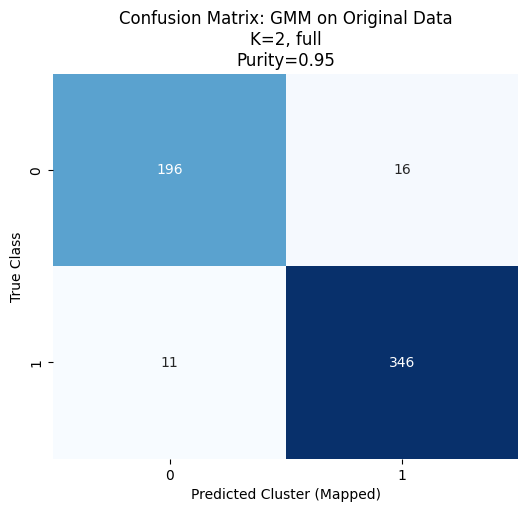

In [185]:
#main execution
print(f"Loaded Data: {X.shape}")

df_results = run_experiments(X, y)

print("\nTop 5 Models by BIC (Lower is Better):")
print(df_results.sort_values(by='BIC').head())

# --- Visualization Requirements ---

# 1. Heatmap: Comparing Purity across Experiments
# We filter for K=2 and Full Covariance to make comparison fair
subset = df_results[
    (df_results['K'] == 2) &
    (df_results['Cov'] == 'full')
].copy()

# Pivot for Heatmap: Index=Experiment, Columns=Dimension
pivot_table = subset.pivot_table(index='Experiment', columns='Dim', values='Purity')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='.3f')
plt.title('Purity Heatmap: Method vs Dimension (K=2, Full Cov)')
plt.show()


# 2. BIC Curves for Experiment 2
exp2_data = df_results[df_results['Experiment'] == 'Exp2']
plt.figure(figsize=(10, 5))
sns.lineplot(data=exp2_data, x='K', y='BIC', hue='Cov', marker='o')
plt.title('Experiment 2: BIC Scores vs Components')
plt.show()

# 3. AIC Curves for Experiment 2
plt.figure(figsize=(10, 5))
sns.lineplot(data=exp2_data, x='K', y='AIC', hue='Cov', marker='o')
plt.title('Experiment 2: AIC Scores vs Components')
plt.show()


print("\n--- Running Silhouette Analysis (K=2 to 10) ---")
k_values = range(2, 11)
sil_scores = []

for k in k_values:
    model = train_gmm(X, k, covariance_type='full')
    score = silhouette_score(X, model['labels'])
    sil_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_values, sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis (GMM - Full Cov)")
plt.show()



exp2_results = df_results[df_results['Experiment'] == 'Exp2']
best_row = exp2_results.loc[exp2_results['Purity'].idxmax()]

k = int(best_row['K'])
cov = best_row['Cov']

# Retrain
model = train_gmm(X, k, cov)
labels = model['labels']

# Match clusters to true classes for better visualization
mapping = match_clusters_to_labels(y, labels)
mapped_labels = np.array([mapping[c] for c in labels])

# Plot
cm = confusion_matrix(y, mapped_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"Confusion Matrix: GMM on Original Data\nK={k}, {cov}\nPurity={best_row['Purity']:.2f}")
plt.xlabel('Predicted Cluster (Mapped)')
plt.ylabel('True Class')
plt.show()
